## Linearize and match (1)

This tutorial reproduces the single DOF illustration case of Prevosto

Note : There is a dependence on Pluto lib for the max entropy solver

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from Snoopy import Spectral as sp

**Input data**

In [3]:
hs = 10.0
tp = 11.3
gamma = 10.0
dw = 0.005
wmax = 3.5

m = 5.35e10
B = 60
L = 250
Cd = 0.1
rho = 1000.
bquad = .5*rho*Cd*B**4*L
blin = 1.4e9
Tr = 11.3
k = m*(2*np.pi/Tr)**2
bcr = 2*(k*m)**0.5
mx = 5.e8

Create Snoopy Seastate

In [4]:
spec = sp.Jonswap(hs = hs , tp = tp , gamma = gamma , heading = np.deg2rad(90.) )
ss = sp.SeaState( spec )

Create constant RAOs

In [5]:
mx_rao = mx * sp.getUnitRao( dw = dw, wmin = 0.1 , wmax = wmax , heading = np.arange(0,2*np.pi , np.deg2rad(30)) )

Solve roll motion in frequency domain (for actual case, this would be done by HydroStar, RAO would just have to be read). 
Note : the unit has to be consistent with the damping one, here roll in thus in radians!

In [6]:
blinList = np.linspace( 0.9*blin , 50.*blin , 50 )
metadata = sp.Rao.getMetaData(mx_rao)
metadata.pop("modesCoefficients")
rollList = [sp.Rao( w = mx_rao.freq , b = mx_rao.head ,
           cvalue = ((mx_rao.cvalues[:,:,0]) / (k + beq*mx_rao.freq*1j - m*mx_rao.freq**2 ))[:,:,np.newaxis] ,
           modesCoefficients = [beq],
           **metadata )
           for beq in blinList ]
rollCollection = sp.Rao(  rollList   )

Create the L&M object that actually does the job

In [7]:
linMatch = sp.LinearizeAndMatch( ss , rollCollection, bLin=0.0 , bQuad=bquad , loadRao = mx_rao , n = 4)

linMatch now contains method to retrieve all results from L&M approach

In [8]:
rollmaxDistribution = linMatch.getMaxDistribution()

For comparison, get maximum distribution from standard stochastic linearization

In [9]:
rollmaxDistribution_ray = sp.StochasticDamping.getMaxDistribution( linMatch )

Text(0.5, 0, 'Roll angle (deg)')

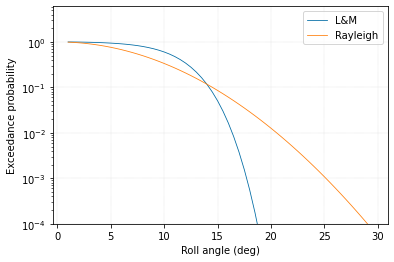

In [10]:
rollAngle = np.arange(1.0 , 30, 0.5)
fig , ax = plt.subplots()
ax.plot(rollAngle , 1-rollmaxDistribution.cdf( np.deg2rad(rollAngle) ) , label ="L&M" )
ax.plot(rollAngle , 1-rollmaxDistribution_ray.cdf( np.deg2rad(rollAngle) ), label = "Rayleigh")
ax.set_yscale("log")
ax.set_ylim(bottom = 1e-4)
ax.legend()
ax.set_ylabel("Exceedance probability")
ax.set_xlabel("Roll angle (deg)")